In [1]:
import numpy as np;from scipy import signal;from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py;import json
import matplotlib.pyplot as plt;import matplotlib.mlab as mlab 
import readligo as rl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load LIGO data.

In [2]:
eventname = 'GW150914'
plottype = "png"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")

In [3]:
# both H1 and L1 will have the same time vector, so:
time = time_H1-time_H1[0]

# Save the data start time in seconds since Jan 6, 1980 GMT
data_start_std = time_H1[0]

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

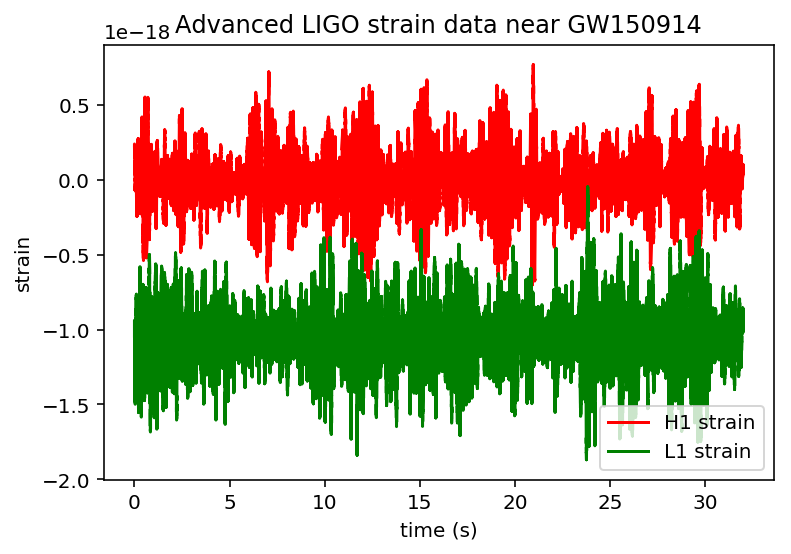

In [4]:
plt.figure()
plt.plot(time,strain_H1,'r',label='H1 strain')
plt.plot(time,strain_L1,'g',label='L1 strain')
plt.xlabel('time (s)');plt.ylabel('strain')
plt.legend(loc='lower right');plt.title('Advanced LIGO strain data near '+eventname)
plt.show()

# Load Template

In [5]:
# Read in the template (plus and cross polarizations of the wave)
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    
template_p, template_c = f_template["template"][...]
t_approx = f_template["/meta"].attrs['approx']
f_template.close()

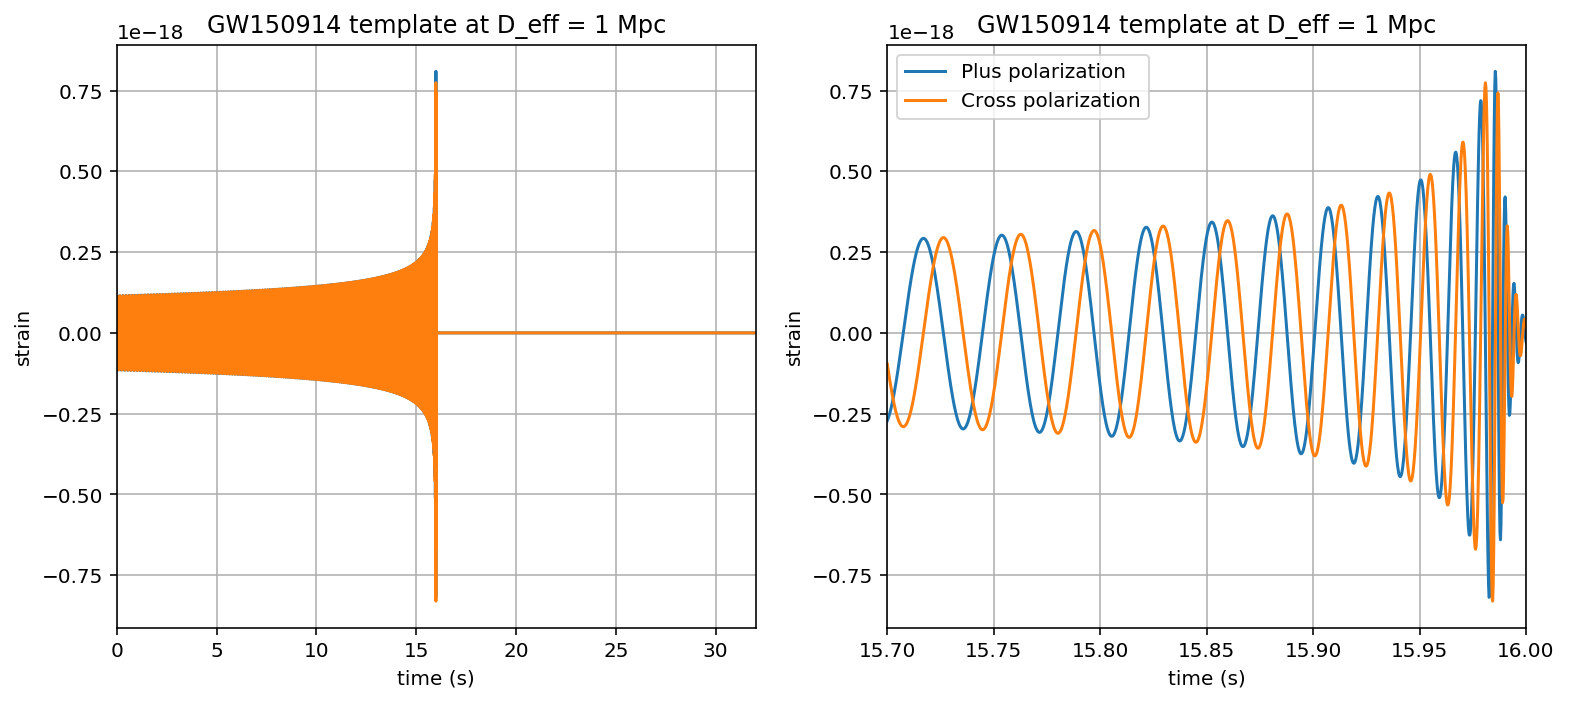

In [6]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))

ax[0].plot(time-time[0],template_p)
ax[0].plot(time-time[0],template_c)
ax[0].set_xlim([0,32]);ax[0].grid()
ax[0].set_xlabel('time (s)');ax[0].set_ylabel('strain');ax[0].set_title(eventname+' template at D_eff = 1 Mpc')

ax[1].plot(time-time[0],template_p,label = "Plus polarization")
ax[1].plot(time-time[0],template_c,label = "Cross polarization")
ax[1].set_xlim([15.7,16]);ax[1].grid();plt.legend()
ax[1].set_xlabel('time (s)');ax[1].set_ylabel('strain');ax[1].set_title(eventname+' template at D_eff = 1 Mpc')

plt.tight_layout()

## NOTE:
Fourier transform normalizations:

\begin{equation}
    \tilde{x}[k] = \Delta t\sum_{j=0}^{N-1} x[j]\ e^{-\frac{2\pi ijk}{N}}
\end{equation}
\begin{equation}
    x[j] = \Delta f\sum_{k=0}^{N-1} \tilde{x}[k]\ e^{\frac{2\pi ijk}{N}}
\end{equation}
Where $\Delta f = \frac{1}{N\Delta t}$. This is the normaliztion suggested by the LIGO team.

## Power Spectral density calculator

In [7]:
NFFT = 4*fs
PSD_WINDOW = np.hanning(NFFT)
NOVL = 0

def PSD(S):
    return signal.welch(S, fs = fs, nfft = NFFT, window=PSD_WINDOW, noverlap=NOVL)

In [8]:
# Max and min frequncies to be plotted for frequency domain representations of data
f_range = [1,2000]

In [9]:
# Compute FT of windowed strain data
l = strain_H1.size
tukey = signal.tukey(l, alpha=1./8)# Tukey window
H1_ft = np.fft.rfft(strain_H1*tukey)*dt
L1_ft = np.fft.rfft(strain_L1*tukey)*dt
freqs = np.fft.rfftfreq(l,d=dt)

In [10]:
# Hamming window
hamming = np.hamming(l) 

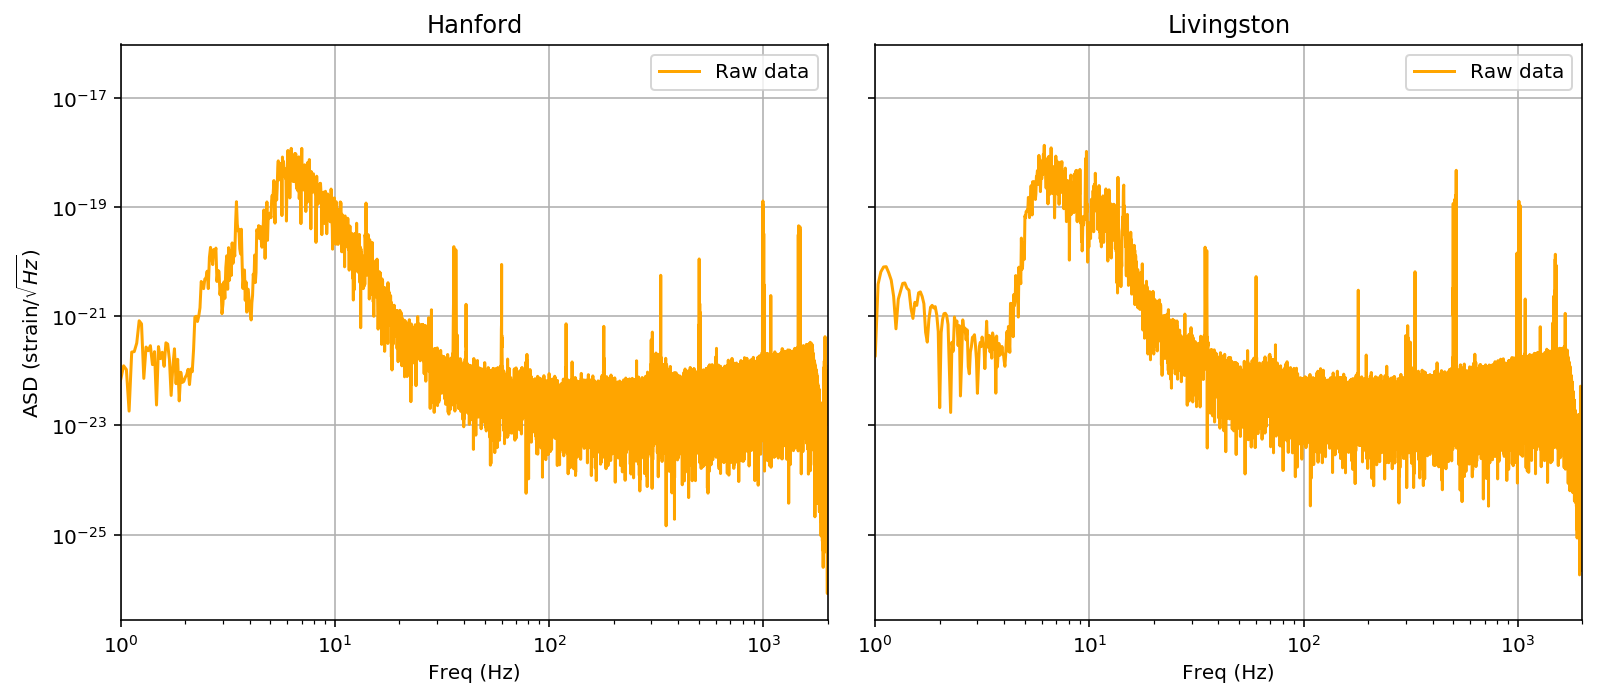

In [11]:
fig, ax = plt.subplots(1, 2,sharey=True,figsize=(11,5))
ax[0].loglog(freqs,abs(H1_ft), 'orange',label = "Raw data")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].grid();ax[0].legend();ax[0].set_xlim(f_range)

ax[1].loglog(freqs,abs(L1_ft), 'orange',label = "Raw data")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].grid();ax[1].legend();ax[1].set_xlim(f_range)

plt.tight_layout()
ax[0].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
plt.show()

$\rightarrow$Noise is reduced by applying Welch's method (a standard averaging technique) on the data

In [12]:
# Compute PSD by Welch's method
H1_f,H1_psd = PSD(strain_H1) #signal.welch(strain_H1,fs,nperseg = 2**int(np.log2(l/8)))
L1_f,L1_psd = PSD(strain_L1) #signal.welch(strain_L1,fs,nperseg = 2**int(np.log2(l/8)))

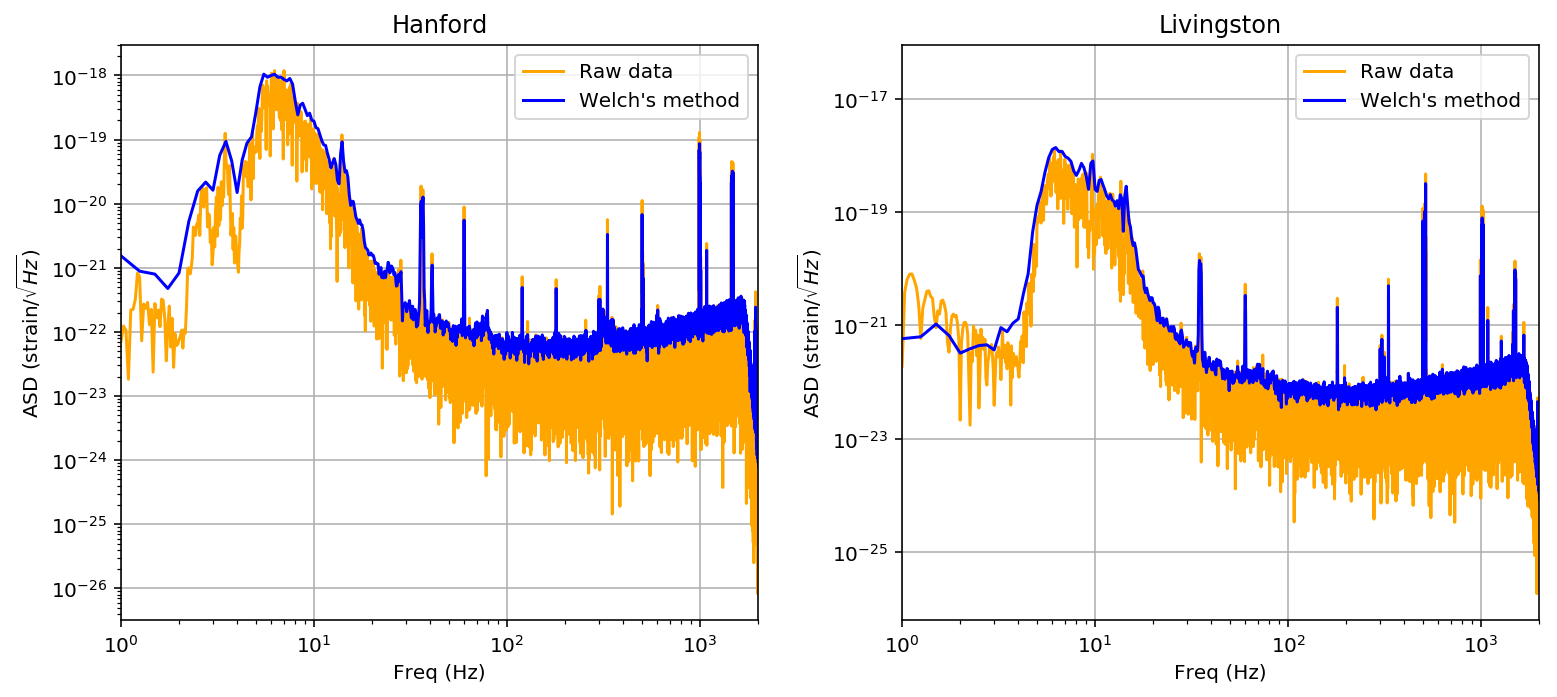

In [13]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))
ax[0].loglog(freqs,abs(H1_ft), color ='orange',label = "Raw data")
ax[0].loglog(H1_f,np.sqrt(2*l*H1_psd/fs), color = 'b',label = "Welch's method")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].grid();ax[0].legend();ax[0].set_xlim(f_range)

ax[1].loglog(freqs,abs(L1_ft), color = 'orange',label = "Raw data")
ax[1].loglog(H1_f,np.sqrt(2*l*L1_psd/fs), color = 'b',label = "Welch's method")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].grid();ax[1].legend();ax[1].set_xlim(f_range)


ax[0].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
ax[1].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
plt.tight_layout()
plt.show()

# Noise model and Data Whitening

The strain data is "whitened" - (divided by the noise amplitude spectrum model, in the fourier domain). This suppresses the extra noise at low frequencies and at the spectral lines, to better resolve the weak signals in the most sensitive band.

$\rightarrow$ The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean noise.

In [14]:
# Noise model
H1_noise_amplitude = interp1d(H1_f, np.sqrt(2*l*H1_psd/fs))
L1_noise_amplitude = interp1d(L1_f, np.sqrt(2*l*L1_psd/fs))

In [15]:
# "Whiten" the data by dividing by the noise amplitude
H1_ft_wh = H1_ft/H1_noise_amplitude(freqs)
L1_ft_wh = L1_ft/L1_noise_amplitude(freqs)

# Go back to the time domain
H1_strain_wh = fs*np.fft.irfft(H1_ft_wh,n=l)
L1_strain_wh = fs*np.fft.irfft(L1_ft_wh,n=l)

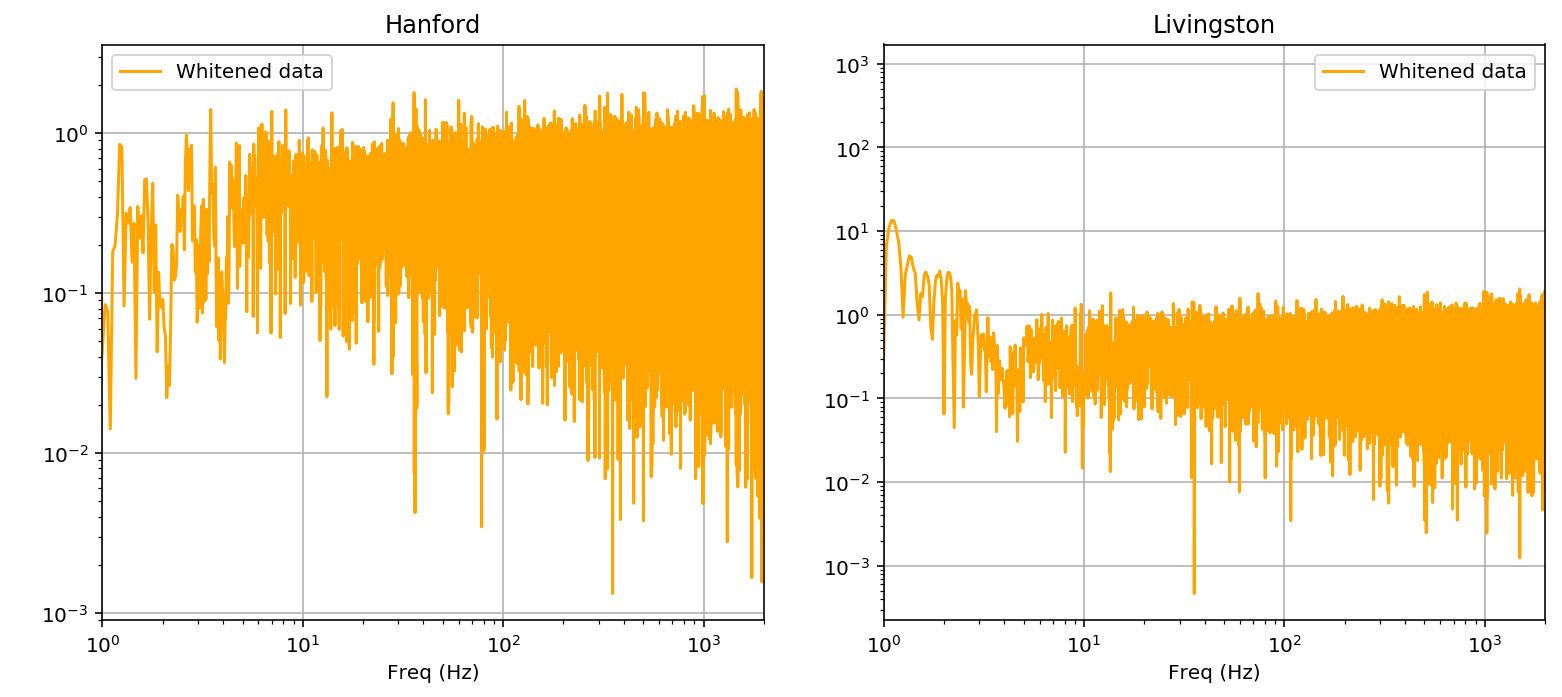

In [16]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))
ax[0].loglog(freqs,abs(H1_ft_wh), color ='orange',label = "Whitened data")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].set_ylabel(' ')
ax[0].grid();ax[0].legend();ax[0].set_xlim(f_range);ax[0].set_ylim(None)

ax[1].loglog(freqs,abs(L1_ft_wh), color = 'orange',label = "Whitened data")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].set_ylabel(' ')
ax[1].grid();ax[1].legend();ax[1].set_xlim(f_range);ax[1].set_ylim(None)

plt.tight_layout()
plt.show()

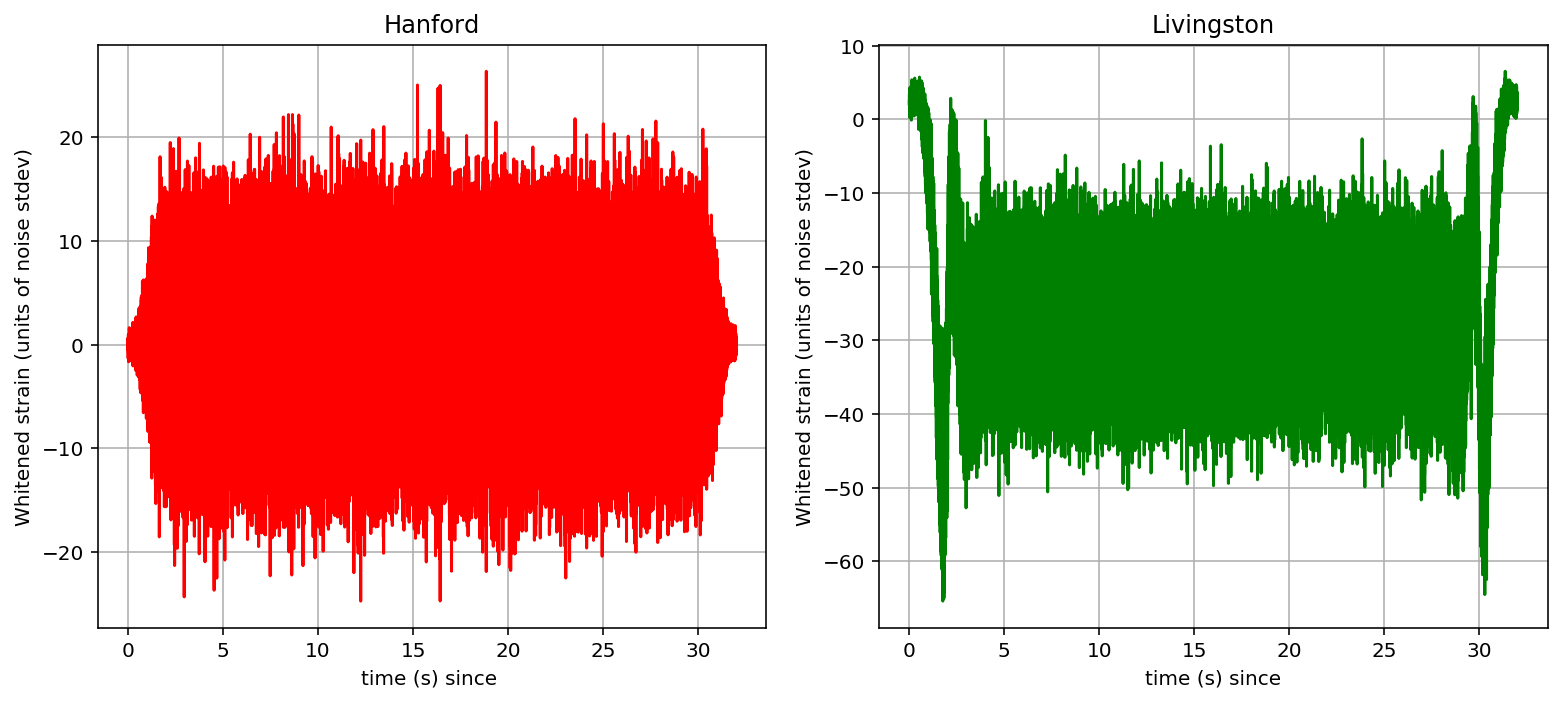

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))

ax[0].plot(time,H1_strain_wh,color='r')
ax[0].set_title("Hanford");ax[0].set_xlabel('time (s) since ');ax[0].set_ylabel("Whitened strain (units of noise stdev)")
ax[0].grid();ax[0].set_xlim(None)

ax[1].plot(time,L1_strain_wh,color='g')
ax[1].set_title("Livingston");ax[1].set_xlabel('time (s) since');ax[1].set_ylabel("Whitened strain (units of noise stdev)")
ax[1].grid();ax[1].set_xlim(None)

plt.tight_layout()
plt.show()

## Bandpass Filter:

Now the signal is not quite yet visible because of low and high frequency noise in regions far outside that of interest.

$\rightarrow$ Apply a Bandpass filter to the remaining signal

$\rightarrow$  $5^{th}$ order Butterworth filter (any order higher than 2 should work)

$\rightarrow$ Low frequency cutoff = 20 Hz

$\rightarrow$ High frequency cutoff = 300 Hz

In [18]:
bb, ab = butter(5, [20*2./fs, fband[1]*2./fs], btype='band') # Same bandpass filter as the ligo tutorial!
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

H1_strain_wh_bd = filtfilt(bb, ab, H1_strain_wh) 
L1_strain_wh_bd = filtfilt(bb, ab, L1_strain_wh)

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


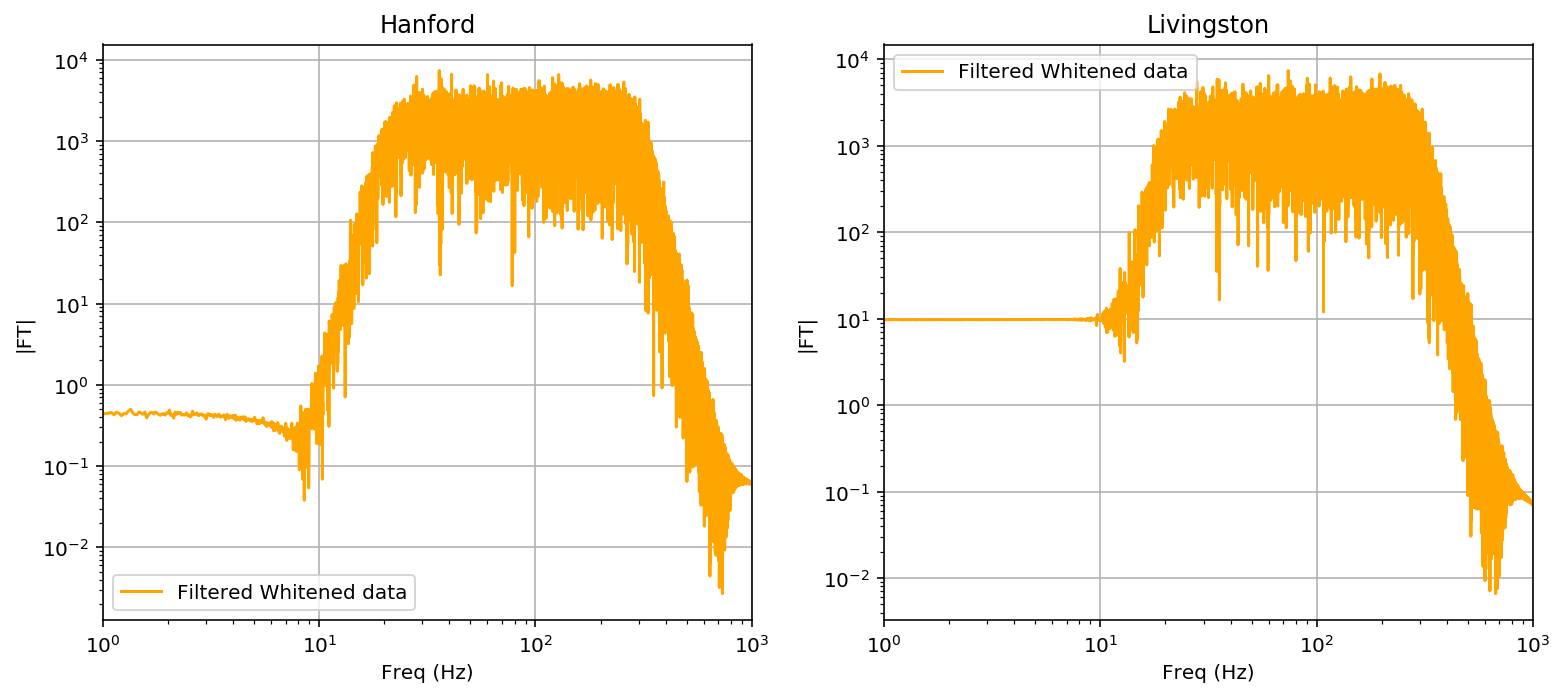

In [19]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))

ax[0].loglog(freqs,np.abs(np.fft.rfft(H1_strain_wh_bd,n=l)),color = "orange",label = "Filtered Whitened data")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].set_ylabel("|FT|")
ax[0].grid();ax[0].legend();ax[0].set_xlim([1,1000])

ax[1].loglog(freqs,np.abs(np.fft.rfft(L1_strain_wh_bd,n=l)),color = "orange",label = "Filtered Whitened data")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].set_ylabel("|FT|")
ax[1].grid();ax[1].legend();ax[1].set_xlim([1,1000])

plt.tight_layout()
plt.show()

$\bullet$ As we can see, the filter has sigificantly suppressed the frequency content outside the main region of interest of $\approx$ 20-300 Hz. 

$\rightarrow$ Now we can plot the full (32.0 s) time domain waveforms, as well as zoomed plots centered on the time of the event as supplied in the Ligo data.

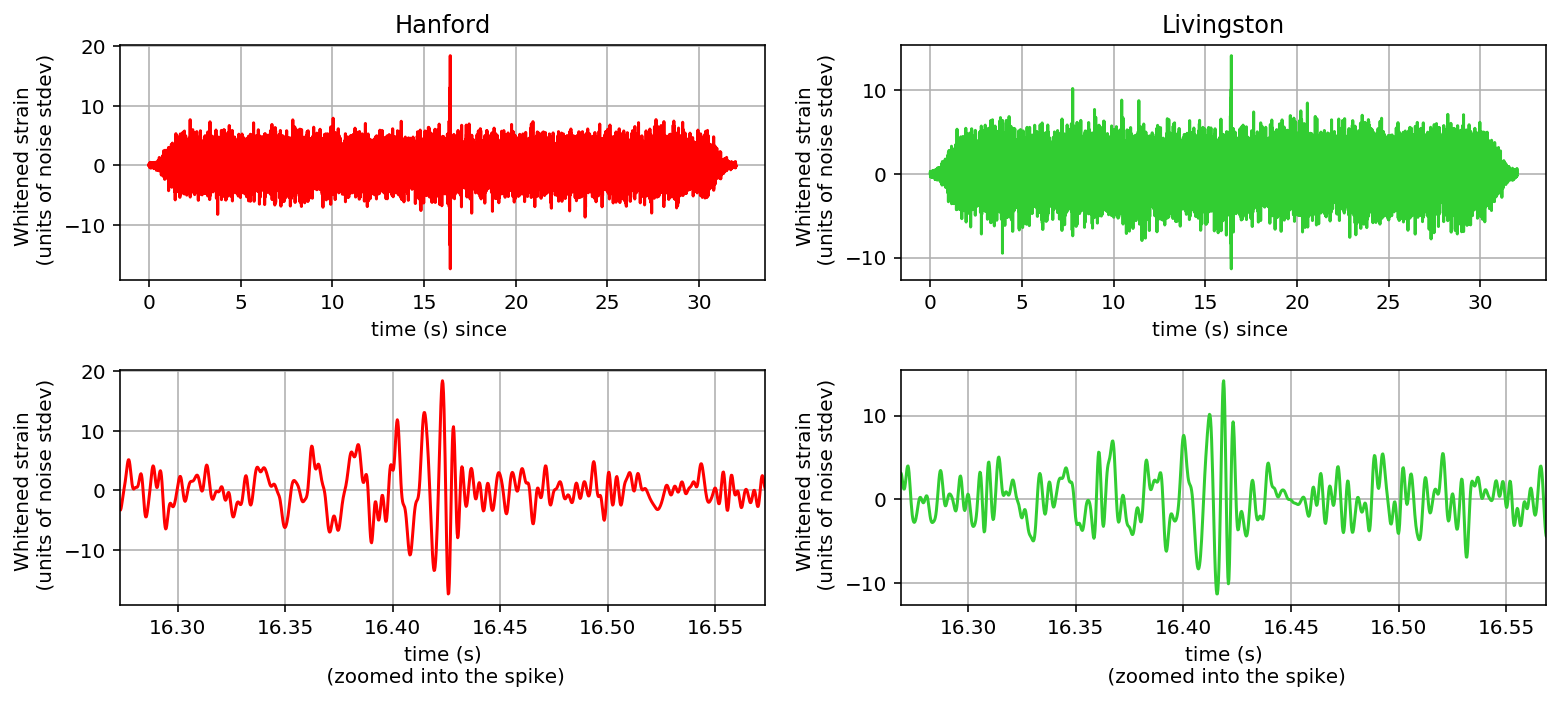

In [74]:
fig, ax = plt.subplots(2, 2,figsize=(11,5))

ax[0,0].plot(time,H1_strain_wh_bd,color='r')
ax[0,0].set_title("Hanford");ax[0,0].set_xlabel('time (s) since ');ax[0,0].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[0,0].grid();ax[0,0].set_xlim(None)

ax[0,1].plot(time,L1_strain_wh_bd,color='limegreen')
ax[0,1].set_title("Livingston");ax[0,1].set_xlabel('time (s) since ');ax[0,1].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[0,1].grid();ax[0,1].set_xlim(None)

H1_max = np.where(H1_strain_wh_bd == max(H1_strain_wh_bd))
L1_max = np.where(L1_strain_wh_bd == max(L1_strain_wh_bd))

ax[1,0].plot(time,H1_strain_wh_bd,color='r')
ax[1,0].set_xlabel('time (s)\n (zoomed into the spike)');ax[1,0].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[1,0].grid();ax[1,0].set_xlim([time[H1_max]-0.15,time[H1_max]+0.15])

ax[1,1].plot(time,L1_strain_wh_bd,color='limegreen')
ax[1,1].set_xlabel('time (s)\n (zoomed into the spike)');ax[1,1].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[1,1].grid();ax[1,1].set_xlim([time[L1_max]-0.15,time[L1_max]+0.15])

plt.tight_layout()
plt.show()

In [21]:
dt = 1/fs

In [22]:
# Template preparation
template = (template_p + template_c*1.j) 
# Plus and cross polarizations of the wave encoded as real and imaginary parts of template.

In [23]:
datafreq = np.fft.fftfreq(template.size)*fs
freqs,H1_psd = PSD(strain_H1)
freqs,L1_psd = PSD(strain_L1)

In [24]:
window = signal.tukey(template.size, alpha=1./8)
df = np.abs(datafreq[1] - datafreq[0])

In [25]:
# Take the Fourier Transform (FFT) of the data and the template (with window)
template_fft = np.fft.fft(template*window)*dt
H1_fft = np.fft.fft(strain_H1*window)*dt
L1_fft = np.fft.fft(strain_L1*window)*dt

# Get the Power Spectral Density values at the needed frequencies (datafreq)
S_n_H1 = np.interp(np.abs(datafreq), freqs, H1_psd)
S_n_L1 = np.interp(np.abs(datafreq), freqs, L1_psd)

# Matched filter implimentation

We pass our whitened signal $s_w(t)$ through a filter with with impulse response $h(t)$, the output is:
\begin{equation}
    y(\tau) = \int_{-\infty}^{\infty} s_w(\tau-t) h(t) dt
\end{equation}

We have a template which represents the ideal gravitational wave signal, and we want to find where in the signal the template waveform lies (if it even does!).  

If we chose $h(t)$ to equal our template waveform, the filter will have the hightest possible signal to noise ratio when the data follows the template. This gives us the best way of finding a known signal buried in noise.

The matched filter calculation is a convolution, which can be simplified using the fourier transform. The matched filter can ultimately be expressed as:
\begin{equation}
    m(t) = 2\int_{-\infty}^{\infty} \frac{\tilde{s}(f)\tilde{h}(f)^*}{S_n(f)}e^{2\pi ift} df
\end{equation}

Where $\tilde{s}(f)$ and $\tilde{h}(f)$ are the fourier transforms of the signal and template waveforms, respectively, and $S_n(f)$ is the spectral power density of the signal.

In [26]:
internal = (H1_fft * template_fft.conjugate()) / S_n_H1
m_H1 = 2*np.fft.ifft(internal)/dt

internal = (L1_fft * template_fft.conjugate()) / S_n_L1
m_L1 = 2*np.fft.ifft(internal)/dt

Since the noise is stationary, the noise variance is given by:
\begin{equation}
    \sigma_m^2 = \int_{-\infty}^{\infty} \frac{|\tilde{h}(f)|^2}{S_n(f)} df
\end{equation}

In [28]:
variance = (template_fft * template_fft.conjugate() / S_n_H1).sum() * df
sigma_H1 = np.sqrt(np.abs(variance))

variance = (template_fft * template_fft.conjugate() / S_n_L1).sum() * df
sigma_L1 = np.sqrt(np.abs(variance))

The amplitude signal to noise ratio is defined as:
\begin{equation}
\rho(t) = \frac{|m(t)|}{\sigma_m}
\end{equation}

In [29]:
m_sigma_H1 = m_H1/sigma_H1
SNR_H1 = np.abs(m_sigma_H1)

m_sigma_L1 = m_L1/sigma_L1
SNR_L1 = np.abs(m_sigma_L1)

## SNR analysis
$\rightarrow$  The SNR will be strongly peaked at the time when the shifted data and template agree.

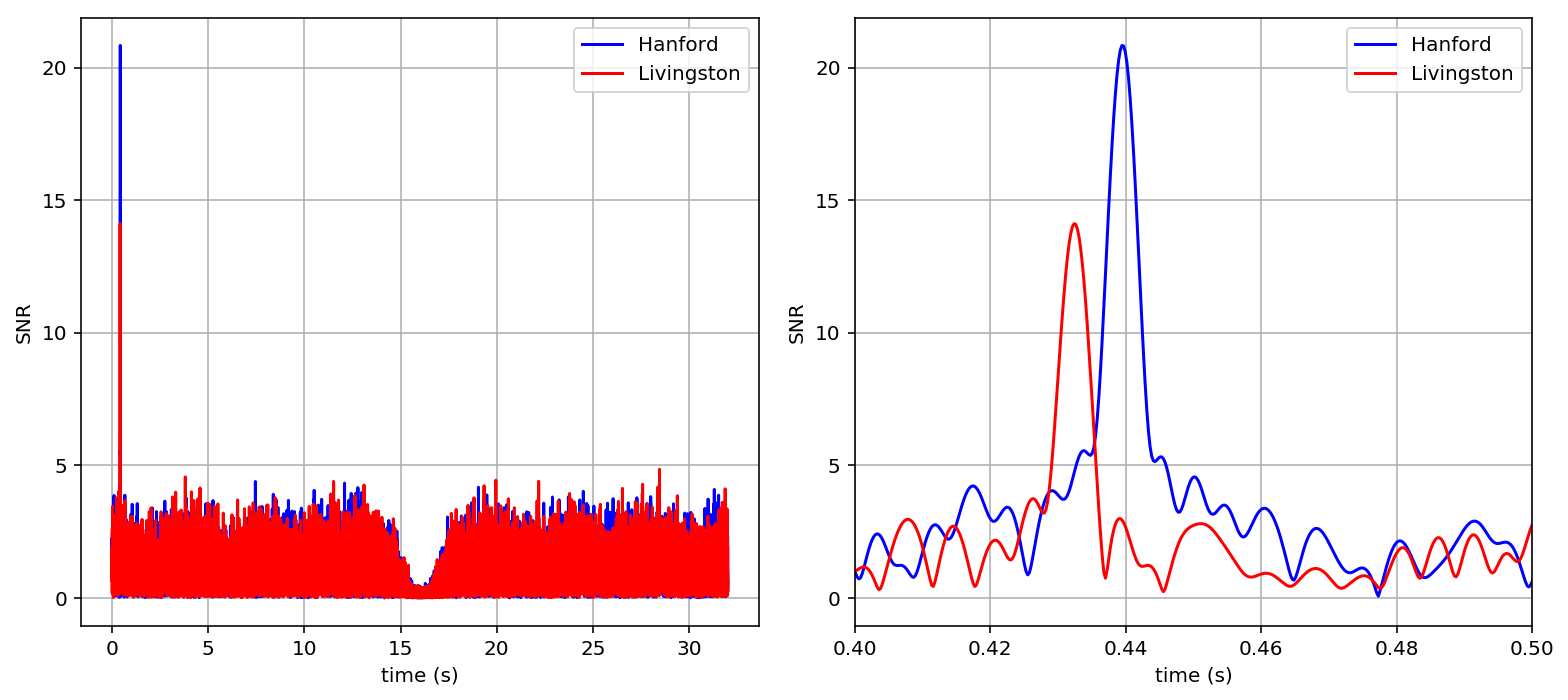

In [30]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))

ax[0].plot(time,SNR_H1,color = "blue",label = "Hanford")
ax[0].plot(time,SNR_L1,color = "red",label = "Livingston")
ax[0].set_xlabel('time (s)');ax[0].set_ylabel("SNR")
ax[0].grid();ax[0].set_xlim(None);ax[0].legend()

ax[1].plot(time,SNR_H1,color = "blue",label = "Hanford")
ax[1].plot(time,SNR_L1,color = "red",label = "Livingston")
ax[1].set_xlabel('time (s)');ax[1].set_ylabel("SNR")
ax[1].grid();ax[1].set_xlim([0.4,0.5]);ax[1].legend()

plt.tight_layout()
plt.show()

## Finding the time offset
$\rightarrow$ Using the index position of the max SNR, we can determine the time offset between each of the data sets from the template!

In [81]:
H1_SNR_index = np.where(SNR_H1 == max(SNR_H1))[0][0]
L1_SNR_index = np.where(SNR_L1 == max(SNR_L1))[0][0]

In [83]:
t_H1 = time[H1_SNR_index]
t_L1 = time[L1_SNR_index]

t_offset = t_H1-t_L1

## Phase shift the template
$\rightarrow$ Get correct phasing between plus and cross polarizations?

In [34]:
phase = np.angle(m_sigma_H1[H1_SNR_index])
template_phaseshifted_H1 = np.real(template*np.exp(1j*phase))   

phase = np.angle(m_sigma_L1[L1_SNR_index])
template_phaseshifted_L1 = np.real(template*np.exp(1j*phase))   

## Whiten and Filter the template

In [35]:
template_phaseshifted_fft = dt*np.fft.rfft(template_phaseshifted_H1*window)
datafreq = np.fft.rfftfreq(template_phaseshifted_H1.size,d=dt)
S_n = np.interp(datafreq, freqs, H1_psd)
template_H1_wh = fs*np.fft.irfft(template_phaseshifted_fft/np.sqrt(2*l*S_n/fs))

template_phaseshifted_fft = dt*np.fft.rfft(template_phaseshifted_L1*window)
datafreq = np.fft.rfftfreq(template_phaseshifted_L1.size,d=dt)
S_n = np.interp(datafreq, freqs, L1_psd)
template_L1_wh = fs*np.fft.irfft(template_phaseshifted_fft/np.sqrt(2*l*S_n/fs))

template_H1_wh_bp = filtfilt(bb, ab, template_H1_wh) 
template_L1_wh_bp = filtfilt(bb, ab, template_L1_wh) 

In [36]:
d_eff_H1 = sigma_H1 / SNR_H1[H1_SNR_index]
d_eff_L1 = sigma_L1 / SNR_L1[L1_SNR_index]

In [46]:
center = 16.

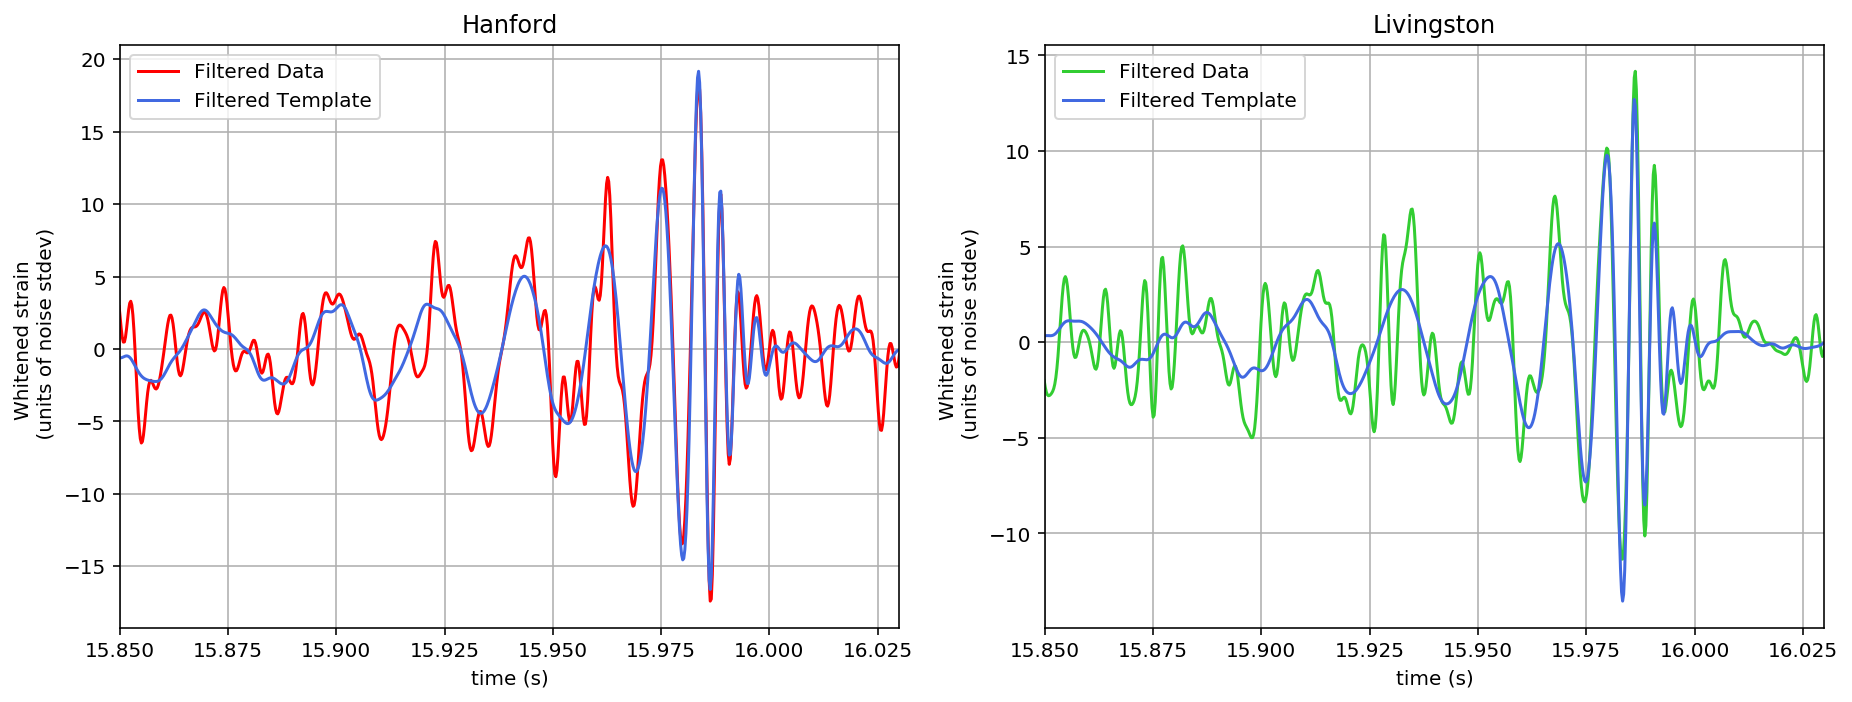

In [76]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))
gr = 16.
ax[0].plot(time-t_H1,H1_strain_wh_bd,color='r',label = "Filtered Data")
ax[0].plot(time,template_H1_wh_bp/d_eff_H1,color='royalblue',label = "Filtered Template")
ax[0].set_title("Hanford");ax[0].set_xlabel('time (s)');ax[0].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[0].grid();ax[0].set_xlim([gr-0.15,gr+0.03]);ax[0].legend(loc=2)


ax[1].plot(time-t_L1,L1_strain_wh_bd,color='limegreen',label = "Filtered Data")
ax[1].plot(time,template_L1_wh_bp/d_eff_L1,color='royalblue',label = "Filtered Template")
ax[1].set_title("Livingston");ax[1].set_xlabel('time (s)');ax[1].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[1].grid();ax[1].set_xlim([gr-0.15,gr+0.03]);ax[1].legend(loc=2)

plt.tight_layout()
plt.show()

In [78]:
t_offset

array([0.00708008])